# MRI registration using ANTS 🐜🐜🐜

Perform some registration experiments using [ANTs](http://stnava.github.io/ANTs). This notebook is intended as a knowledge repository of some of the existing possibilities of ANTs. The full documentation can be found [here](https://antspy.readthedocs.io/en/latest).

In [1]:
import os
import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

Select a pair to images to register. In the first experiment, we register a T1-w (3mm thickness) against the MNI T1-w template (1mm). Images are loaded using `ants.image_read`, which returns a `ANTsImage` object. Compared to `nibabel`, loading times in `ANTs`are significantly lower. `ANTsImage` objects are a combinaton of a `nibabel`object and a `numpy` array.

In [2]:
MNI_TEMPLATE = 'data/MNI152_T1_1mm.nii.gz'
IM = 'data/T1.nii.gz'
fixed_image = ants.image_read(MNI_TEMPLATE)
moving_image = ants.image_read(IM)
fixed_image

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

## 1. Affine registration

Compute the **Affine** transformation using the `ants.registration` function. `ANTs` supports more than ten registration transformations including *Linear*, *Affine*, *Elastix*, *Syn*, etc.. See [here](https://antspy.readthedocs.io/en/latest/registration.html) for more information: 


In [3]:
%%time
mytx = ants.registration(fixed=fixed_image,
                        moving=moving_image,
                        type_of_transform='Affine')


CPU times: user 4min 39s, sys: 1.9 s, total: 4min 41s
Wall time: 13.1 s


Running the registration function at `mic`, the method registers the T1-w image against the MNI template in `13 secs`. The method returns a dictionary containing the moving image warped to the MNI space, the MNI image warped to the moving space and both the forward and backward transformations. Transformations are stored in a list, which means that several transformations can be concatenated to avoid interpolation. 

In [4]:
mytx

{'warpedmovout': ANTsImage (RPI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (182, 218, 182)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (-90.0, 126.0, -72.0)
 	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.],
 'warpedfixout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 48)
 	 Spacing    : (0.9583, 0.9583, 3.0)
 	 Origin     : (-118.6107, -127.1819, 13.3168)
 	 Direction  : [ 0.9973  0.0503 -0.0535 -0.023   0.9059  0.4228  0.0697 -0.4204  0.9046],
 'fwdtransforms': ['/tmp/tmpo7nlkg780GenericAffine.mat'],
 'invtransforms': ['/tmp/tmpo7nlkg780GenericAffine.mat']}

Visualization is another awesome feature of ANTS. Plotting options are:

+ plot: with overlay between two images
+ ortho
+ ortho double
+ histogram
+ surf
+ surf function

The number of slices shown can be selected using `nslices` or particulary controlled by `slices` parameters. 
See [documentation](https://antspy.readthedocs.io/en/latest/vis.html) for more information.

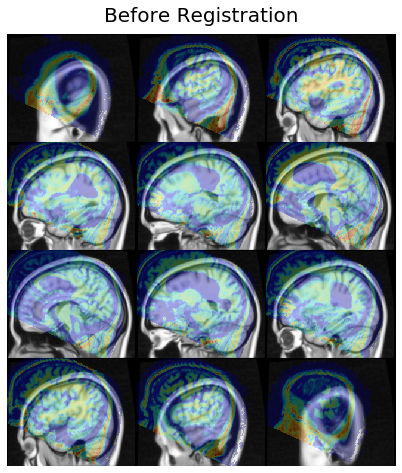

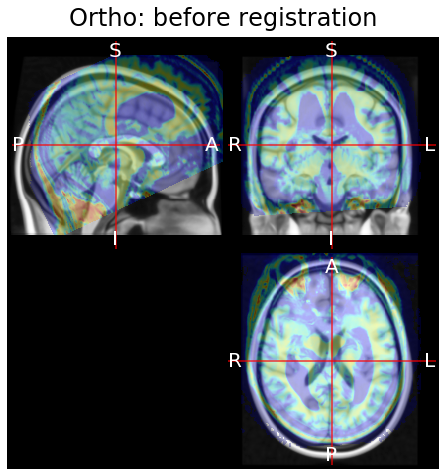

In [5]:
fixed_image.plot(overlay=moving_image, overlay_alpha=0.3, title='Before Registration'),
fixed_image.plot_ortho(overlay= moving_image, overlay_alpha=0.3, title='Ortho: before registration')

Saving the warped image is as simple as saving to a filename as `to_filename(im_path)`, similar to `nibabel`. 👌👌

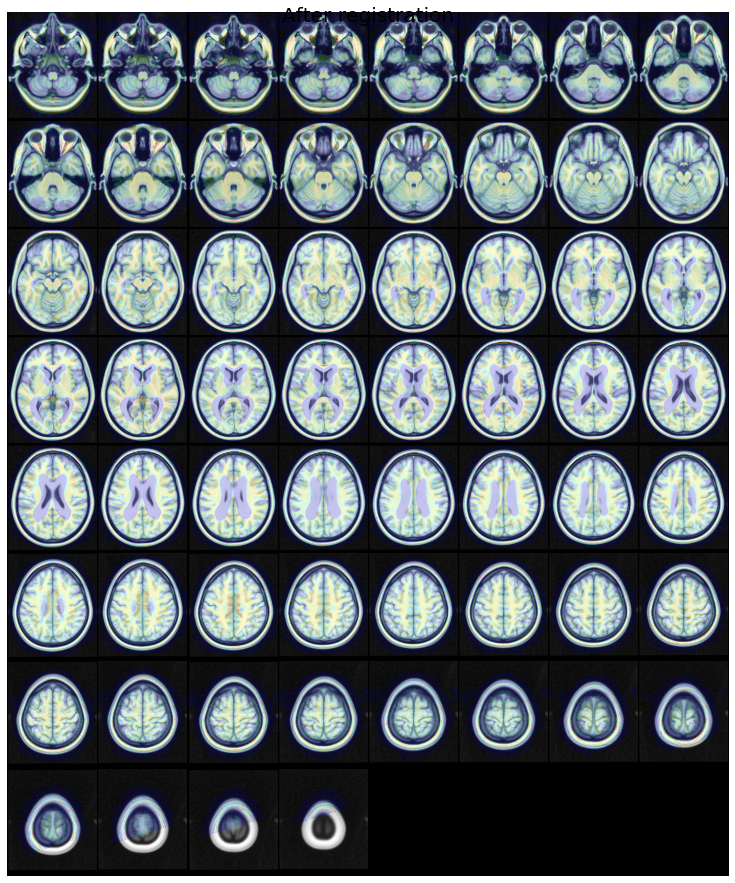

In [6]:
IM_OUT = '/home/sergivalverde/DATA/tmp/T1_MNI_rigid.nii.gz'
warped_moving = mytx['warpedmovout']
warped_moving.to_filename(IM_OUT)

# we show the final registration
fixed_image.plot(overlay=warped_moving, overlay_alpha=0.2, nslices=60, axis=2, title='After registration')

## 2. Non-rigid registration
As a second experiment, we experiment with non-linear registration between two FLAIR images (same patient with two-different time points) 

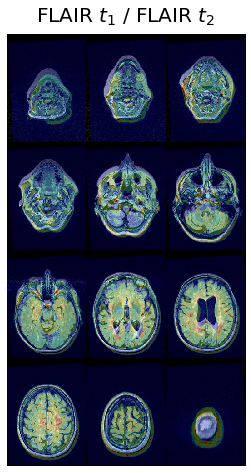

In [7]:
FLAIR_time1 = ants.image_read('data/FLAIR_time1.nii.gz')
FLAIR_time2 = ants.image_read('data/FLAIR_time2.nii.gz')
FLAIR_time1.plot(overlay=FLAIR_time2, overlay_alpha=0.3, title="FLAIR $t_1$ / FLAIR $t_2$", axis=2)


Compute first the affine registration between the two images:


In [8]:
%%time
mytx = ants.registration(fixed=FLAIR_time2,
                        moving=FLAIR_time1,
                        type_of_transform='Affine')

CPU times: user 7min 51s, sys: 3.31 s, total: 7min 55s
Wall time: 21.4 s


Affine registration is performed in `21 sec.`. Plot the resulting registered images:

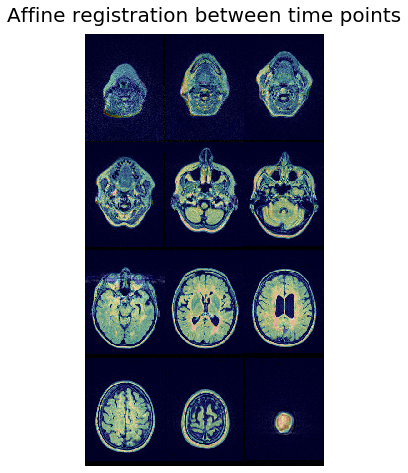

In [9]:
moved_image = mytx['warpedmovout']
FLAIR_time2.plot(overlay=moved_image, overlay_alpha=0.3, title='Affine registration between time points', axis=2)

Secondly, we compute the non-linear registration using [SyN](https://www.ncbi.nlm.nih.gov/pubmed/1765999) ~using the `demons` metric~ and directly without any prior initialization from the affine registration:

In [10]:
%%time
mytx_syn = ants.registration(fixed=FLAIR_time2,
                            moving=FLAIR_time1,
                            # syn_metric='demons',
                            type_of_transform='SyN')

CPU times: user 9min 4s, sys: 5.91 s, total: 9min 10s
Wall time: 45.8 s


`ANTs` performs the non-linear registration between the two images in less than a minute (again running at `mic`). The obtained results can be seen here, comparing them with the affine registration: 


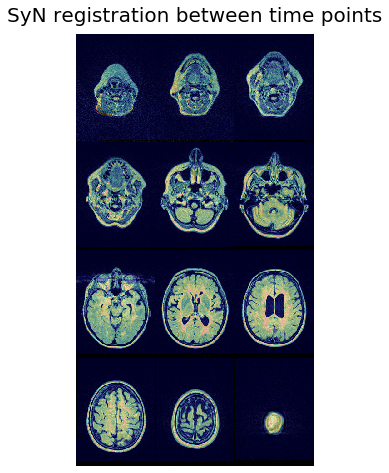

In [11]:
moved_syn_image = mytx_syn['warpedmovout']
FLAIR_time2.plot(overlay=moved_syn_image, overlay_alpha=0.3, title='SyN registration between time points', axis=2)

Finally, we compute the deformation grid and the Jacobian determinant from the obtained transformation 😰🤔

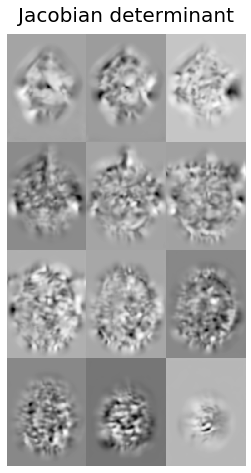

In [15]:
jacobian_det = ants.create_jacobian_determinant_image(FLAIR_time2, mytx_syn['fwdtransforms'][0], 1)
def_grid = ants.create_warped_grid(image=FLAIR_time1,
                                  grid_directions=(True,True),
                                  transform=mytx_syn['fwdtransforms'],
                                  fixed_reference_image=FLAIR_time2)
# FLAIR_time2.plot(overlay=moved_syn_image, overlay_alpha=0.3, title='SyN registration between time points', axis=2)
jacobian_det.plot(title='Jacobian determinant', axis=2)
# def_grid.plot(title='Deformation grid', axis=2) <-- doesn't work well enough, maybe more iterations are needed. 

Save all the images back to the disk:



In [21]:
if not os.path.exists('data/syn'):
    os.mkdir('data/syn/')
moved_image.to_filename('data/syn/FLAIR_time1_affine.nii.gz')
moved_syn_image.to_filename('data/syn/FLAIR_time1_syn.nii.gz')
jacobian_det.to_filename('data/syn/jacobian_determinant.nii.gz')
def_grid.to_filename('data/syn/deformation_grid.nii.gz')